# Steps to follow in order to get the selected interpration by using LLama:
1. run all data train and test with the new prompt with llama
2. interpretations = calculate_prior_probability(interpretations, w_llm=0.5, w_bscore =0.7)
3. interpretations = calculate_fit_quality(interpretations,w_rwp=1, w_score=0.5)
4. interpretations = calculate_posterior_probability_of_interpretation(interpretations)


Make sure LLM_interpretation_likelihood is updated with the LLama's answer & you store the final prior and fit_quality and posterior with different name, do not overwrite the excisting one. Then we can compare the selected interpretation(higher prob) by using Chatgpt vs LLama vs "lowset rwp valus"

In [17]:
def calculate_prior_probability(interpretations, w_llm=1, w_bscore=1):
    # Update each interpretation with a new field "prior_probability"
    for interpretation_name, interpretation in interpretations.items():
        if interpretation_name != "Synth_Conditions":
            interpretation["prior_probability_llama"] = (
           (interpretation["LLM_interpretation_likelihood_llama"]*w_llm + interpretation["balance_score"]*w_bscore)/(w_llm + w_bscore))     
        else: continue 
        
    return interpretations

In [18]:
def calculate_fit_quality(interpretations, w_rwp=1, w_score=1):
    for key, interpretation in interpretations.items():
        if key != "Synth_Conditions":
            interpretation["fit_quality"] = (interpretation["normalized_rwp"]*w_rwp + interpretation["normalized_score"]*w_score) / (w_rwp + w_score)
    return interpretations

In [19]:
def calculate_posterior_probability_of_interpretation(interpretations):
    """
    Calculate the posterior probabilities P(In | S) for all interpretations
    using balance_score and interpretation_importance.
    
    Parameters:
        interpretations (dict or list): A dictionary of interpretations or 
                                        a list containing a single dictionary.

    Returns:
        dict: Updated interpretations with added "posterior_probability" field.
    """
    # Extract dictionary if interpretations is a list
    if isinstance(interpretations, list) and len(interpretations) == 1:
        interpretations = interpretations[0]  # Extract the dictionary

    if not isinstance(interpretations, dict):
        raise ValueError("Interpretations should be a dictionary or a list containing a dictionary.")

     # Step 1: Compute unnormalized posterior = prior * fit_quality
    joint_probabilities = {}
    for name, interp in interpretations.items():
        if name != "Synth_Conditions":
            joint = interp["prior_probability_llama"] * interp["fit_quality"]
            interpretations[name]["unnormalized_posterior_llama"] = joint
            joint_probabilities[name] = joint

    # Step 2: Normalize to get posterior_probability
    total_joint = sum(joint_probabilities.values())
    for name in interpretations:
        if name != "Synth_Conditions":
            if total_joint > 0:
                interpretations[name]["posterior_probability_llama"] = (
                interpretations[name]["unnormalized_posterior_llama"] / total_joint
            )
        else:
            interpretations[name]["posterior_probability_llama"] = 0.0

    return interpretations  

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

def load_json(file_path): # Load JSON Data
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                print("JSON decode error — file is empty or malformed.")
                return {}
    else:
        return {}  # Return empty dict if file doesn't exist


def update_json(data, key, value): # Modify/Add Data
    data[key] = value
    return data

def save_json(file_path, data): # Save JSON Data
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

In [ ]:
file_path = "Data/prompt2/interpretations_llm_v5.1_llama10.json"
json_file = load_json(file_path)
for sample in json_file:
    interpretations = json_file[sample]
    interpretations = calculate_prior_probability(interpretations, w_llm=0.5, w_bscore =0.7)
    interpretations = calculate_fit_quality(interpretations,w_rwp=1, w_score=0.5)
    interpretations = calculate_posterior_probability_of_interpretation(interpretations)
    json_file[sample] = interpretations

save_json("Data/prompt2/interpret_results1.json",json_file)

In [26]:
json_file = load_json("Data/prompt2/interpret_results1.json")
sample_choice = {}
for sample in json_file:
    sample_choice[sample] = {}
    llama_probs = []
    chat_probs = []
    for interpretation in json_file[sample]:
        if interpretation != "Synth_Conditions":
            llama_probs.append((interpretation,json_file[sample][interpretation]["posterior_probability_llama"]))
            chat_probs.append((interpretation,json_file[sample][interpretation]["posterior_probability"]))
    llama_choice = max(llama_probs, key=lambda x: x[1])[0]
    chat_choice = max(chat_probs, key=lambda x: x[1])[0]
    sample_choice[sample]["llama_choice"] = llama_choice
    sample_choice[sample]["chat_choice"] = chat_choice

for sample, choices in sample_choice.items():
    print(f"{sample}")
    print(f"Chat GPT: {choices["chat_choice"]}")
    print(f"Llama: {choices["llama_choice"]}")   

PG_1048_1
Chat GPT: I_3
Llama: I_3
ARR_39
Chat GPT: I_1
Llama: I_2
TRI_62
Chat GPT: I_7
Llama: I_1
TRI_84
Chat GPT: I_2
Llama: I_3
TRI_80
Chat GPT: I_1
Llama: I_1
PG_0849_1
Chat GPT: I_2
Llama: I_1
TRI_81
Chat GPT: I_2
Llama: I_1
TRI_90
Chat GPT: I_1
Llama: I_1
TRI_106
Chat GPT: I_2
Llama: I_2
TRI_114
Chat GPT: I_1
Llama: I_1
TRI_183
Chat GPT: I_4
Llama: I_4
TRI_41
Chat GPT: I_2
Llama: I_1
TRI_87
Chat GPT: I_5
Llama: I_5
ARR_46
Chat GPT: I_3
Llama: I_3
TRI_105
Chat GPT: I_1
Llama: I_3


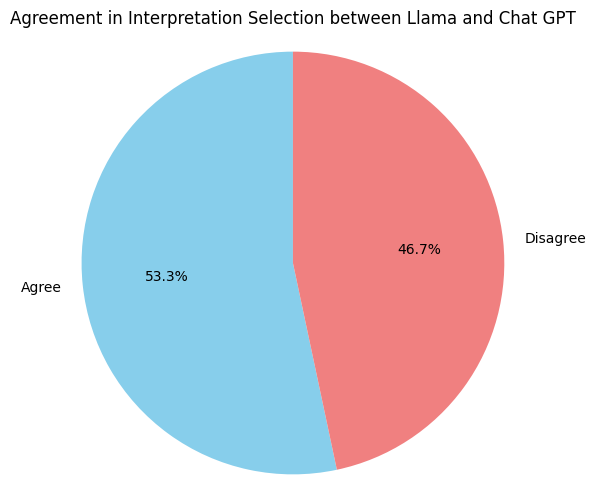

In [27]:
agree = 0 
disagree = 0 
for sample, choices in sample_choice.items():
    if choices["chat_choice"] == choices["llama_choice"]:
        agree += 1
    else: disagree += 1

values = [agree, disagree]  
labels = ['Agree', 'Disagree']  # Replace with your labels
colors = ['skyblue', 'lightcoral']  # Optional: customize colors

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Agreement in Interpretation Selection between Llama and Chat GPT')
plt.axis('equal')  # Ensures pie is a circle
plt.show()

In [28]:
for sample, choices in sample_choice.items():
    if choices["chat_choice"] == choices["llama_choice"]:
        print(f"{sample}: Agree")
    else: print(f"{sample}: Disagree ({choices["chat_choice"]},{choices["llama_choice"]})")

PG_1048_1: Agree
ARR_39: Disagree (I_1,I_2)
TRI_62: Disagree (I_7,I_1)
TRI_84: Disagree (I_2,I_3)
TRI_80: Agree
PG_0849_1: Disagree (I_2,I_1)
TRI_81: Disagree (I_2,I_1)
TRI_90: Agree
TRI_106: Agree
TRI_114: Agree
TRI_183: Agree
TRI_41: Disagree (I_2,I_1)
TRI_87: Agree
ARR_46: Agree
TRI_105: Disagree (I_1,I_3)


In [25]:
failed_dicts = load_json("Data/prompt2/LLM_failedDictionary.json")

response = failed_dicts["Data/prompt2/interpretations_llm_v5.1_llama9.json"]["ARR_39"]
print(response)

Here is the evaluation of the given synthesis data:

```python
{
"I_1": {
    "Likelihoods": {
    "Ga33O50 (space group 12)": 0.0,
    },
    "Explanations": {
    "Ga33O50 (space group 12)": [
        "The phase Ga33O50 does not match the expected target composition GaSbO4.",
        "The oxidation states and composition do not align with the precursors and synthesis conditions.",
        "Ga33O50 is approximately equal to Ga2O3, which is a plausible precursor but not the target phase."
    ],
    "Interpretation_Likelihood": 0.0,
    "Interpretation_Explanation": "This interpretation is highly implausible due to the large discrepancy in composition and the absence of Sb-containing phases."
},

"I_2": {
    "Likelihoods": {
    "Ga2O3 (space group 12)": 0.6,
    },
    "Explanations": {
    "Ga2O3 (space group 12)": [
        "Ga2O3 is a plausible precursor and may remain unreacted under the synthesis conditions.",
        "The space group 12 for Ga2O3 is correct (monoclinic Ga2O3)."